# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

%%bash
rm dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")

    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time
import sklearn.metrics as me 

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:0.5, net.lr:lr})

                        train_batch()
                        #summary_writer_train.add_summary(summary_str, epoch)
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()


                    valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)


                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score = me.f1_score(actual_value, pred_value)
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test_, 
                                                                             net.y_: preprocess.y_test_, 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    
                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:
                        Train.best_acc = accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}".format(h,f),
                                        global_step = epochs)
                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_, "Actual": actual_value_})
                        
                        Train.predictions.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred_, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [9]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        print("********************************** Training ******************************")

        global df_results
        global past_scores
        Train.predictions = {}
        Train.predictions_ = {}

        Train.results = []
    
        
        features_arr = [1, 12, 24, 48, 122]
        hidden_layers_arr = [1, 3]

        epochs = [5]
        lrs = [1e-5, 1e-6]
        print("********************************** Entering Loop ******************************")

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []

        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions_.items():
            dict1_.update({k: v1_})

        Train.predictions = dict1
        Train.predictions_ = dict1_
        
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")
            past_scores = past_scores.append(df_results, ignore_index=True)
        past_scores.to_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

In [10]:
#%%timeit -r 10
#capture
Hyperparameters.start_training()

********************************** Training ******************************
********************************** Entering Loop ******************************
Current Layer Attributes - epochs:5 hidden layers:1 features count:1
Step 1 | Training Loss: 0.704092 | Validation Accuracy: 0.645896
Accuracy on Test data: 0.6112934947013855, 0.33789029717445374
Step 2 | Training Loss: 0.640290 | Validation Accuracy: 0.774488
Accuracy on Test data: 0.690693736076355, 0.4293670952320099
Step 3 | Training Loss: 0.607380 | Validation Accuracy: 0.851961
Accuracy on Test data: 0.7224538922309875, 0.48219409584999084
Step 4 | Training Loss: 0.557025 | Validation Accuracy: 0.880060
Accuracy on Test data: 0.7379790544509888, 0.5088607668876648
Step 5 | Training Loss: 0.513937 | Validation Accuracy: 0.913081
Accuracy on Test data: 0.7531493902206421, 0.5367088317871094
Step 1 | Training Loss: 0.517118 | Validation Accuracy: 0.920384
Accuracy on Test data: 0.7543914318084717, 0.5390717387199402
Step 2 | Trai

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 1 | Training Loss: 0.693097 | Validation Accuracy: 0.529925
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.693101 | Validation Accuracy: 0.533021
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.693125 | Validation Accuracy: 0.537625
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 4 | Training Loss: 0.692802 | Validation Accuracy: 0.536276
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: 0.692893 | Validation Accuracy: 0.531513
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 1 | Training Loss: 0.692826 | Validation Accuracy: 0.539609
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.692912 | Validation Accuracy: 0.530402
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.692909 | Validation Accuracy: 0.535482
Accuracy on Test data: 0.4307576

In [11]:
#g = df_results.groupby(by=['no_of_features'])
#idx = g['test_score'].transform(max) == df_results['test_score']
#df_results[idx].sort_values(by = 'test_score', ascending = False)

In [12]:
#g = df_results.groupby(by=['no_of_features'])
#idx = g['test_score_20'].transform(max) == df_results['test_score_20']
#df_results[idx].sort_values(by = 'test_score_20', ascending = False)

In [13]:
#df_results.sort_values(by = 'test_score', ascending = False)

In [14]:
#Train.predictions_

In [15]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions__.pkl")

df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [17]:
#plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

In [18]:
#plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [19]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

In [20]:
past_scores.sort_values(by='f1_score',ascending=False)

,epoch,f1_score,f1_score_20,hidden_layers,no_of_features,test_score,test_score_20,time_taken,train_score
1110,12,0.873902,0.834989,3.0,48.0,0.866971,0.757553,18.979939,0.924750
1109,10,0.873501,0.834416,3.0,48.0,0.866616,0.756878,17.183680,0.923797
1108,8,0.873269,0.834071,3.0,48.0,0.866439,0.756540,15.182953,0.926258
1107,6,0.872948,0.833669,3.0,48.0,0.866128,0.756034,13.206024,0.926258
1076,4,0.872752,0.831559,1.0,24.0,0.867237,0.755696,6.615212,0.907049
1078,6,0.872539,0.831315,1.0,24.0,0.867060,0.755443,5.527226,0.901810
1112,3,0.868402,0.841002,3.0,122.0,0.851579,0.747764,4.354387,0.860137
1086,4,0.862763,0.823989,1.0,122.0,0.852378,0.733755,7.787664,0.916574
1077,5,0.862754,0.818941,1.0,24.0,0.858011,0.740253,4.420664,0.892046
1088,6,0.862359,0.824165,1.0,122.0,0.851845,0.733755,6.520284,0.919114


In [21]:
psg = past_scores.sort_values(by='test_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='test_score', ascending=False)

epoch  f1_score  f1_score_20  test_score  \
no_of_features hidden_layers                                             
24.0           1.0                4  0.872752     0.831559    0.867237   
48.0           3.0               12  0.873902     0.834989    0.866971   
122.0          1.0                4  0.862763     0.823989    0.852378   
               3.0                3  0.868402     0.841002    0.851579   
48.0           1.0                6  0.854733     0.806544    0.847232   
12.0           1.0               12  0.837183     0.785078    0.833348   
               3.0               12  0.857121     0.839242    0.830509   
24.0           3.0                4  0.826648     0.765712    0.821904   
1.0            1.0               12  0.749205     0.650831    0.758650   
               3.0                2  0.000000     0.000000    0.430758   

                              test_score_20  time_taken  train_score  
no_of_features hidden_layers                                          
24.0           1.0                 0.755696    6.615212     0.907049  
48.0           3.0                 0.757553   18.979939     0.924750  
122.0          1.0                 0.733755    7.787664     0.916574  
               3.0                 0.747764    4.354387     0.860137  
48.0           1.0                 0.715612    5.875551     0.913796  
12.0           1.0                 0.696624   10.911904     0.897841  
               3.0                 0.730211   16.995091     0.801873  
24.0           3.0                 0.667173   10.274888     0.910462  
1.0            1.0                 0.545992   10.894768     0.933561  
               3.0                 0.181603    1.590742     0.529925

In [22]:
psg.mean().sort_values(by='test_score', ascending=False)

epoch  f1_score  f1_score_20  test_score  \
no_of_features hidden_layers                                             
122.0          3.0             2.50  0.865028     0.855632    0.840090   
24.0           1.0             4.00  0.842248     0.816444    0.837420   
48.0           1.0             4.00  0.846614     0.808136    0.835433   
               3.0             6.25  0.818815     0.777829    0.825375   
24.0           3.0             4.00  0.815525     0.761104    0.808357   
122.0          1.0             4.00  0.819843     0.824216    0.795369   
12.0           1.0             6.25  0.800505     0.772256    0.791918   
               3.0             6.25  0.806903     0.843851    0.744910   
1.0            1.0             6.25  0.709750     0.603261    0.727805   
               3.0             2.00  0.000000     0.000000    0.430758   

                              test_score_20  time_taken  train_score  
no_of_features hidden_layers                                          
122.0          3.0                 0.761941    3.274703     0.803143  
24.0           1.0                 0.734751    3.987215     0.813462  
48.0           1.0                 0.714194    3.464890     0.863423  
               3.0                 0.698460   10.472351     0.908398  
24.0           3.0                 0.659646    6.163162     0.881251  
122.0          1.0                 0.723190    4.691176     0.824067  
12.0           1.0                 0.679694    6.445614     0.816836  
               3.0                 0.735390   10.099620     0.673401  
1.0            1.0                 0.498439    6.430936     0.867102  
               3.0                 0.181603    1.590742     0.529925

In [23]:
Train.predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
Train.predictions_ = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions__.pkl")

In [24]:
#epoch_nof_hidden
Train.predictions["12_12_3"]

,Actual,Attack_prob,Normal_prob,Prediction
0,1.0,0.290404,0.709596,1.0
1,1.0,0.290311,0.709689,1.0
2,0.0,0.441519,0.558481,1.0
3,1.0,0.204695,0.795305,1.0
4,1.0,0.359508,0.640492,1.0
5,0.0,0.666080,0.333920,0.0
6,0.0,0.522911,0.477089,0.0
7,1.0,0.135548,0.864452,1.0
8,0.0,0.662445,0.337555,0.0
9,1.0,0.586753,0.413247,0.0


In [25]:
Train.predictions_["12_12_3"]

,Actual,Attack_prob,Normal_prob,Prediction
0,1.0,0.403012,0.596988,1.0
1,1.0,0.396761,0.603239,1.0
2,1.0,0.011543,0.988457,1.0
3,0.0,0.342929,0.657071,1.0
4,1.0,0.100866,0.899134,1.0
5,1.0,0.570735,0.429265,0.0
6,1.0,0.104104,0.895896,1.0
7,1.0,0.395437,0.604562,1.0
8,0.0,0.329435,0.670565,1.0
9,0.0,0.482691,0.517309,1.0


In [26]:
df = Train.predictions["12_12_3"].dropna()
df_ = Train.predictions_["12_12_3"].dropna()

In [27]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}


In [28]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test+"})
score_df = pd.DataFrame(scores, index=[0])

scores = get_score(df_.loc[:,'Actual'].values.astype(int),
                df_.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test-"})

score_df = score_df.append(pd.DataFrame(scores, index=[1]))

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.830509,0.857121,0.823940,0.893088,Train+/Test+
1,0.730211,0.839242,0.819021,0.860487,Train+/Test-


In [29]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

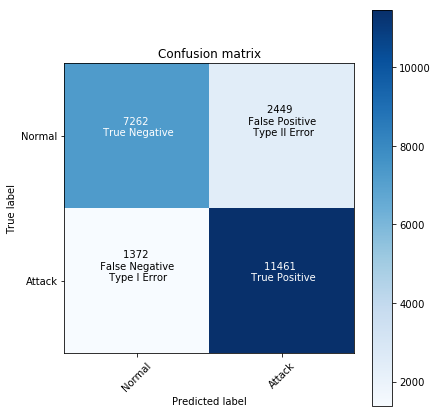

In [30]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [31]:
df_.groupby(by="Actual").Actual.count()

Actual
0.0    2152
1.0    9698
Name: Actual, dtype: int64

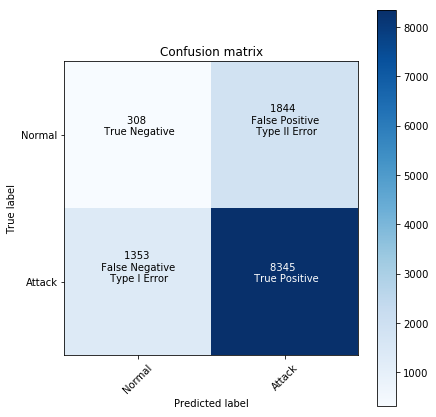

In [32]:
plot(actual_value = df_.loc[:,'Actual'].values.astype(int),
     pred_value = df_.loc[:,'Prediction'].values.astype(int))

In [33]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)

no_of_features  hidden_layers
1.0             1.0              (0.578452539765, 0.841046710607)
                3.0                                    (nan, nan)
12.0            1.0              (0.668723301504, 0.932285711705)
                3.0              (0.636233676898, 0.977571551948)
24.0            1.0                (0.7637835282, 0.920711831434)
                3.0               (0.783714231971, 0.84733658272)
48.0            1.0              (0.817941844822, 0.875285309714)
                3.0                (0.60901468163, 1.02861547867)
122.0           1.0              (0.665214663577, 0.974471096522)
                3.0              (0.855675801742, 0.874380756313)
dtype: object